In [26]:
import numpy as np
import matplotlib.pyplot as plt
from ngsolve import *
from ngsolve.webgui import Draw

In [101]:
import importlib
import sys
from pathlib import Path
import os 
sys.path.append(str(Path(os.getcwd()).parent / "src"))

import catch_bond_fem
importlib.reload(catch_bond_fem)

import utils 
importlib.reload(utils)

from ngsolve.webgui import Draw

In [102]:

left_edge = 0.5 - 0.05
right_edge = 0.5 + 0.05
tanh = lambda arg: (exp(arg) - exp(-arg))/(exp(arg)+exp(-arg)) 
left_transition = 0.5 * (tanh((x - left_edge)/0.01))
right_transition = 0.5 * (tanh((right_edge - x)/0.01))
source = 1*(left_transition + right_transition) 

T = 100
tau = 0.01
chi0 = 0.1
chi1 = 1
beta_prod = 1
beta2 = 1
beta1 = beta_prod/beta2
eta = 1 
rho0 = 1 + 0.5*source 

sim = catch_bond_fem.CatchBond1D(
        width=1, maxh=0.01,
        gamma=eta, eta_1=eta, eta_2=0,
        k=1, D= 1e-4,
        kappa =1e-4,
        beta1 = beta1, beta2 = beta2, 
        chi0 = chi0,  chi1 = chi1, 
        rho0 = lambda t: rho0, Qsq = lambda t: source, 
        )


# for i in range(len(sim.density.vec.data)): 
#     sim.density.vec.data[i] = np.random.normal(1, 0.05)
#     sim.nematic_xx.vec.data[i] = np.random.normal(0, 0.05)

sim.simulate(
    tend=T,
    tau=tau,
    save_interval=100 # save once a second 
)


  5%|▌         | 532/10000 [00:00<00:03, 2928.46it/s]

craete bilinearformapplication


100%|██████████| 10000/10000 [00:02<00:00, 4982.49it/s]


In [103]:
data = sim.export_to_npy(100)

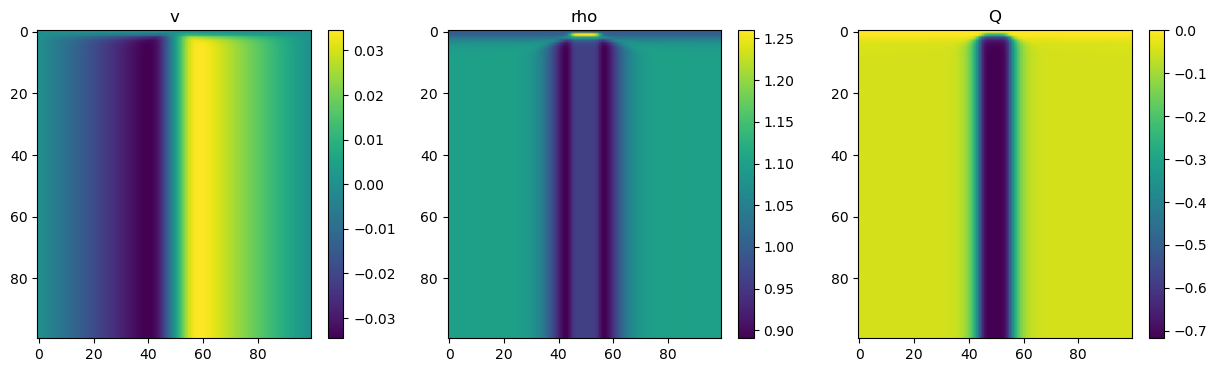

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im0 = axes[0].imshow(data[:, :, 1], aspect='auto')
axes[0].set_title('v')
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(data[:, :, 0], aspect='auto')
axes[1].set_title('rho')
fig.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(data[:, :, -1], aspect='auto')
axes[2].set_title('Q')
fig.colorbar(im2, ax=axes[2])


plt.show()

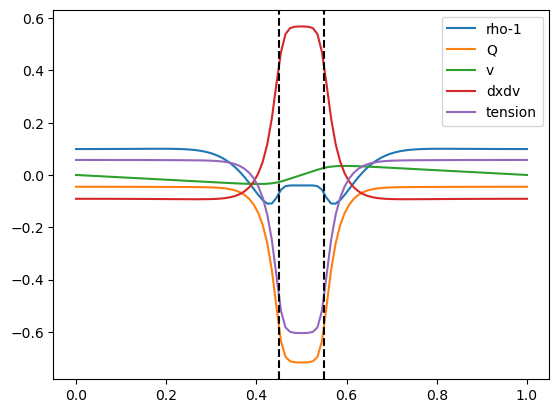

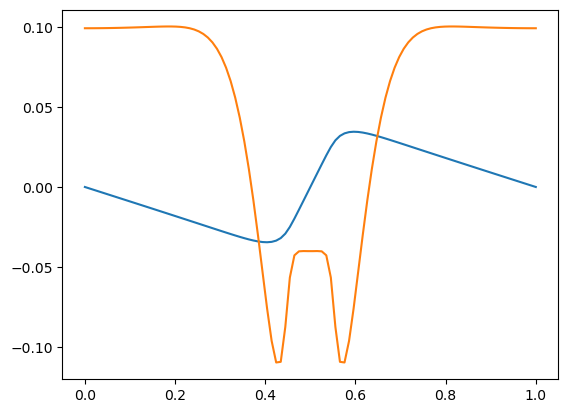

In [105]:
t = -1 
X = np.linspace(0, 1, 100)

rho, v, Q = data[t].T 
dxdv = np.gradient(v, (0.01))
rho_diff = rho - 1 
plt.plot(X, rho_diff, label='rho-1')
plt.plot(X, Q, label='Q')
plt.plot(X, v, label='v')
plt.plot(X, dxdv, label='dxdv')
plt.plot(X, 2*rho*(chi0 + chi1*Q)/(rho+1), label='tension')
plt.axvline(x=right_edge, color='k', linestyle='--')
plt.axvline(x=left_edge, color='k', linestyle='--')  
plt.legend() 
plt.show() 

plt.plot(X, v, label='v')
plt.plot(X, rho_diff)
plt.show() 

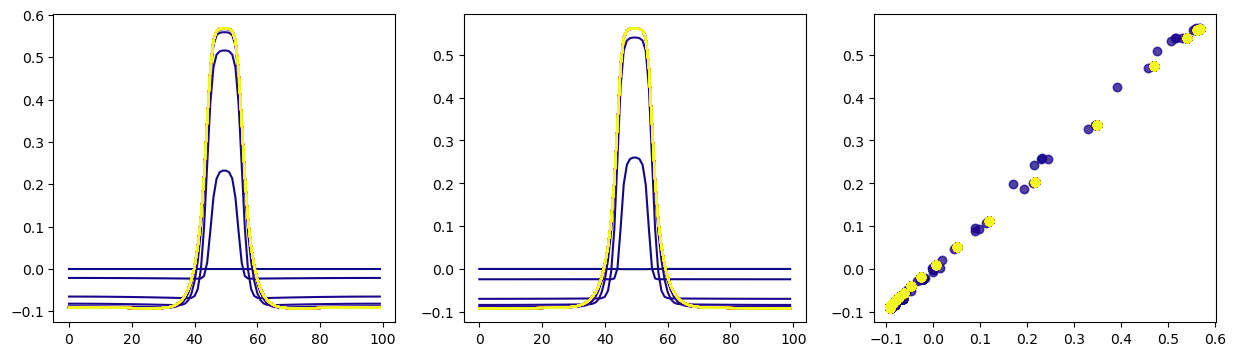

In [106]:
rho = data[:, :, 0] 
v = data[:, :, 1]
Q = data[:, :, 2]

dxdv = np.gradient(v, (0.01), axis=-1) 

T = len(dxdv)
colors = plt.cm.plasma(np.linspace(0, 1, T))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i in range(T): 
    axes[0].plot(dxdv[i], color=colors[i])

    tension = -rho[i]*(chi0+chi1*Q[i])
    axes[1].plot(tension-np.mean(tension), color=colors[i])
    axes[2].plot(dxdv[i], tension-np.mean(tension), 'o', alpha=0.5, color=colors[i])
plt.show() 

[-0.10008174 -1.00486753]
0.1 1


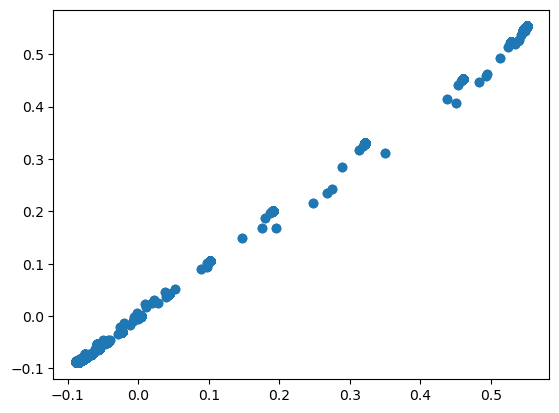

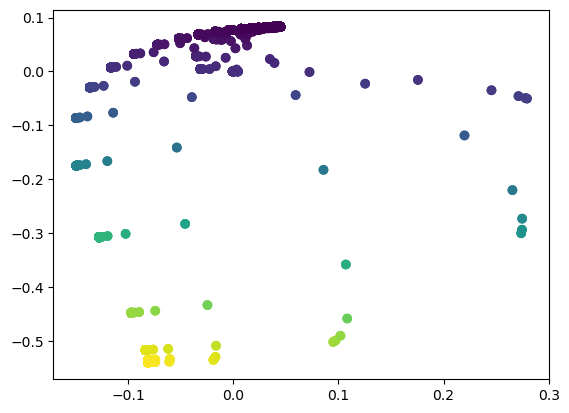

In [95]:
from sklearn.linear_model import LinearRegression

A = (rho - np.mean(rho, axis=-1)[:, np.newaxis]).flatten()
B = (Q*rho - np.mean(Q*rho, axis=-1)[:, np.newaxis]).flatten()
C = np.column_stack((A, B))
f = dxdv.flatten() 

model = LinearRegression(fit_intercept=False)  # No intercept as our function doesn't have one
model.fit(C, f)
a, b= model.coef_ 

print(model.coef_)
print(chi0, chi1)

plt.scatter(a*A + b*B, f)
plt.show() 

plt.scatter(A, B, c=f)
